## 成交量与未平仓量


In [1]:
from datetime import datetime, timedelta

startTime = datetime(2022,12,1)
endTime = datetime(2023,2, 1)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import talib as ta
import numpy as np

In [4]:
symbolList = ['btc_usdt.spot:binance', 'eth_usdt.spot:binance']

client = pymongo.MongoClient('172.16.20.81', 27017)

In [5]:
def readDb(collection, start, end):
    return pd.DataFrame(
        list(collection.find({"datetime": {'$gt': start, '$lt': end}}))
    )

In [6]:
dbClient = client['Kline_1Min_Auto_Db_Plus']
columnsName = ['open', 'high', 'low', 'close', 'volume','datetime']

In [7]:
crytoDict = {
                'btc':readDb(dbClient[symbolList[0]], start=startTime , end=endTime)[columnsName],
                'eth':readDb(dbClient[symbolList[1]], start=startTime , end=endTime)[columnsName]
            }

In [8]:
def resampleDf(data, freq='H'):
#     df = data.drop('_id', axis=1)
    dataDf = data.set_index('datetime')
    dataHourDf = dataDf.resample(freq).agg({'open':'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume':'sum'})
    dataResetDf = dataHourDf.reset_index()
    return dataResetDf

def resampleOiDf(data, freq='H'):
    dataDf = data.set_index('datetime')
    dataHourDf = dataDf.resample(freq).agg({'oi':'last'})
    dataResetDf = dataHourDf.reset_index()
    return dataResetDf

In [9]:
def addSymbol(dataDf, symbolName):  
    dataDf['symbol'] = symbolName
    return dataDf

In [10]:
def setIndex(dataDf):
    dataIndex = dataDf.set_index(['datetime', 'symbol'])
    return dataIndex

In [11]:
multiCryptoDict = {}
for key, df in crytoDict.items():
    hourDf = resampleDf(df)
    hourSymbolDf = addSymbol(hourDf, key)
    hourIndexDf = setIndex(hourSymbolDf)
    multiCryptoDict[key] = hourIndexDf

In [12]:
multiDf = pd.concat(list(multiCryptoDict.values())).sort_index()

In [13]:
multiDf

open      high       low     close  \
datetime            symbol                                           
2022-12-01 00:00:00 btc     16865.77  16907.90  16828.55  16861.98   
                    eth      1267.98   1279.40   1264.66   1273.41   
2022-12-01 01:00:00 btc     16861.98  16876.52  16720.56  16789.66   
                    eth      1273.42   1274.29   1261.24   1266.10   
2022-12-01 02:00:00 btc     16789.66  16986.00  16705.00  16921.44   
...                              ...       ...       ...       ...   
2023-01-31 21:00:00 eth      1573.67   1588.73   1572.89   1588.14   
2023-01-31 22:00:00 btc     23126.94  23197.38  23056.00  23119.64   
                    eth      1588.13   1589.56   1579.77   1583.09   
2023-01-31 23:00:00 btc     23118.76  23206.84  23075.01  23121.80   
                    eth      1583.09   1596.13   1581.92   1588.99   

                                 volume  
datetime            symbol               
2022-12-01 00:00:00 btc     10681.62990  
                    eth     41861.81810  
2022-12-01 01:00:00 btc     11525.93872  
                    eth     28077.17630  
2022-12-01 02:00:00 btc     19892.70775  
...                                 ...  
2023-01-31 21:00:00 eth     32104.34380  
2023-01-31 22:00:00 btc     19857.46975  
                    eth     17105.19810  
2023-01-31 23:00:00 btc     14842.22274  
                    eth     17516.30530  

[2976 rows x 5 columns]

In [14]:
btcOi = pd.read_csv('btcOi.csv')
ethOi = pd.read_csv('ethOi.csv')

In [15]:
btcOi.tail()

Unnamed: 0   timestamp          oi      notional             datetime
17275       17275  1670065500  129771.135  2.199595e+09  2022-12-03 19:05:00
17276       17276  1670065200  129735.207  2.199707e+09  2022-12-03 19:00:00
17277       17277  1670064900  129720.446  2.199579e+09  2022-12-03 18:55:00
17278       17278  1670064600  129728.198  2.199180e+09  2022-12-03 18:50:00
17279       17279  1670064300  129672.042  2.197431e+09  2022-12-03 18:45:00

In [16]:
btcOiDf = btcOi[['oi', 'notional', 'datetime']]
ethOiDf = ethOi[['oi', 'notional', 'datetime']]

In [17]:
btcOiDf['datetime'] = list(map(lambda dt: datetime.strptime(dt, "%Y-%m-%d %H:%M:%S"), btcOiDf['datetime']))
ethOiDf['datetime'] = list(map(lambda dt: datetime.strptime(dt, "%Y-%m-%d %H:%M:%S"), ethOiDf['datetime']))

In [18]:
btcOi = setIndex(addSymbol(resampleOiDf(btcOiDf), 'btc'))
ethOi = setIndex(addSymbol(resampleOiDf(ethOiDf), 'eth'))

In [19]:
oiDf = pd.concat([btcOi, ethOi]).sort_index()

In [20]:
oiVolumeDf = pd.concat([multiDf, oiDf], axis=1).dropna()

In [21]:
oiVolumeDf

open      high       low     close  \
datetime            symbol                                           
2022-12-03 18:00:00 btc     16979.13  16984.50  16951.47  16963.51   
                    eth      1273.55   1273.55   1269.58   1271.33   
2022-12-03 19:00:00 btc     16963.51  16965.66  16880.88  16943.43   
                    eth      1271.33   1271.33   1260.54   1269.39   
2022-12-03 20:00:00 btc     16943.43  16968.99  16930.42  16965.71   
...                              ...       ...       ...       ...   
2023-01-31 21:00:00 eth      1573.67   1588.73   1572.89   1588.14   
2023-01-31 22:00:00 btc     23126.94  23197.38  23056.00  23119.64   
                    eth      1588.13   1589.56   1579.77   1583.09   
2023-01-31 23:00:00 btc     23118.76  23206.84  23075.01  23121.80   
                    eth      1583.09   1596.13   1581.92   1588.99   

                                 volume           oi  
datetime            symbol                            
2022-12-03 18:00:00 btc      4956.11650   129720.446  
                    eth      6365.87220  1503942.764  
2022-12-03 19:00:00 btc      9684.26894   129429.417  
                    eth     16374.21960  1495373.362  
2022-12-03 20:00:00 btc      6461.23071   129868.580  
...                                 ...          ...  
2023-01-31 21:00:00 eth     32104.34380   992941.132  
2023-01-31 22:00:00 btc     19857.46975    99640.982  
                    eth     17105.19810   999166.504  
2023-01-31 23:00:00 btc     14842.22274   100021.193  
                    eth     17516.30530   997785.981  

[2844 rows x 6 columns]

In [22]:
btcOiVolumeData = oiVolumeDf.loc[:,pd.IndexSlice['btc'],:]
ethOiVolumeData = oiVolumeDf.loc[:,pd.IndexSlice['eth'],:]

In [23]:
shortPeriod = 168
longPeriod = shortPeriod*4

In [24]:
btcOiVolumeData['closeSma'] = btcOiVolumeData['close'].rolling(shortPeriod).mean()
btcOiVolumeData['closeLma'] = btcOiVolumeData['close'].rolling(longPeriod).mean()
btcOiVolumeData['closeRatio'] = btcOiVolumeData['closeSma']/btcOiVolumeData['closeLma']
btcOiVolumeData['volumeSma'] = btcOiVolumeData['volume'].rolling(shortPeriod).mean()
btcOiVolumeData['volumeLma'] = btcOiVolumeData['volume'].rolling(longPeriod).mean()
btcOiVolumeData['volumeRatio'] = btcOiVolumeData['volumeSma']/btcOiVolumeData['volumeLma']
btcOiVolumeData['oiSma'] = btcOiVolumeData['oi'].rolling(shortPeriod).mean()
btcOiVolumeData['oiLma'] = btcOiVolumeData['oi'].rolling(longPeriod).mean()
btcOiVolumeData['oiRatio'] = btcOiVolumeData['oiSma']/btcOiVolumeData['oiLma']

In [25]:
btcOiVolumeDf = btcOiVolumeData.dropna()

In [30]:
from bokeh.layouts import column
from math import pi
from bokeh.plotting import figure
from bokeh.io import output_notebook,show
from bokeh.resources import INLINE
import bokeh.io
from bokeh import *
bokeh.io.output_notebook(INLINE)

inc = btcOiVolumeDf.close > btcOiVolumeDf.open
dec = btcOiVolumeDf.open > btcOiVolumeDf.close
PUVU = (btcOiVolumeDf['closeRatio']>1) & (btcOiVolumeDf['volumeRatio']>1)
PDVD = (btcOiVolumeDf['closeRatio']<1) & (btcOiVolumeDf['volumeRatio']<1)
PUVD = (btcOiVolumeDf['closeRatio']>1) & (btcOiVolumeDf['volumeRatio']<1)
PDVU = (btcOiVolumeDf['closeRatio']<1) & (btcOiVolumeDf['volumeRatio']>1)

w = 12*60*60*100

## Candlestick chart
candlestick = figure(x_axis_type="datetime", plot_width=900, plot_height=350, title = "BTC", toolbar_location=None)

candlestick.segment(btcOiVolumeDf.index[inc], btcOiVolumeDf.high[inc], btcOiVolumeDf.index[inc], btcOiVolumeDf.low[inc], color="green")
candlestick.segment(btcOiVolumeDf.index[dec], btcOiVolumeDf.high[dec], btcOiVolumeDf.index[dec], btcOiVolumeDf.low[dec], color="red")

candlestick.vbar(btcOiVolumeDf.index[inc], w, btcOiVolumeDf.open[inc], btcOiVolumeDf.close[inc],
         fill_color="green", line_color="green")

candlestick.vbar(btcOiVolumeDf.index[dec], w, btcOiVolumeDf.open[dec], btcOiVolumeDf.close[dec],
         fill_color="red", line_color="red")


candlestick.line(btcOiVolumeDf.index[PUVU], btcOiVolumeDf.close[PUVU], line_color="green", line_width=5, legend_label="Price Up and Volume Up")
candlestick.line(btcOiVolumeDf.index[PDVD], btcOiVolumeDf.close[PDVD], line_color="red", line_width=5, legend_label="Price Down and Volume Down")
# candlestick.line(btcOiVolumeDf.index[PUVD], btcOiVolumeDf.close[PUVD], line_color="yellow", line_width=5, legend_label="PUVD")
# candlestick.line(btcOiVolumeDf.index[PDVU], btcOiVolumeDf.close[PDVU], line_color="white", line_width=5, legend_label="PDVU")
candlestick.line(btcOiVolumeDf.index, btcOiVolumeDf['closeSma'], line_color="blue", line_width=1.5, legend_label="closeSma")
candlestick.line(btcOiVolumeDf.index, btcOiVolumeDf['closeLma'], line_color="yellow", line_width=1.5, legend_label="closeLma")
candlestick.legend.location = "top_left"

# candlestick.line(btcOiVolumeDf.index, btcOiVolumeDf.close.rolling(28).mean(), line_color="yellow", line_width=1.5, name="closeLma")

# candlestick.line([datetime(2023,1,21), datetime(2023,1,31)], [btcOiVolumeDf.close[datetime(2023,1,21)], btcOiVolumeDf.close[datetime(2023,1,31)]], legend_label="7DaysChange", line_color="red", line_width=2, alpha=0.8, line_dash='dashed')
## SMA & EMA
# candlestick.line(btcOiVolumeDf.index, btcOiVolumeDf.close.rolling(5).mean(), line_color="yellowgreen", line_width=1.5, name="SMA")

## Volume Chart
volume = figure(x_axis_type="datetime", x_range=candlestick.x_range, plot_width=900, plot_height=200, toolbar_location=None)

volume.vbar(btcOiVolumeDf.index, width=w, top=btcOiVolumeDf.volume,
            fill_color="green", line_color="green", alpha=0.3)
volume.line(btcOiVolumeDf.index, btcOiVolumeDf['volumeSma'], line_color="blue", line_width=1.5, name="volumeSma")
volume.line(btcOiVolumeDf.index, btcOiVolumeDf['volumeLma'], line_color="yellow", line_width=1.5, name="volumeLma")
# volumeRatioIndex = btcOiVolumeDf.volume.rolling(shortPeriod).mean()/btcOiVolumeDf.volume.rolling(longPeriod).mean()
# priceRatioIndex = btcOiVolumeDf.close.rolling(shortPeriod).mean()/btcOiVolumeDf.close.rolling(longPeriod).mean()

# volumeRatio = figure(x_axis_type="datetime", x_range=volume.x_range, plot_width=800, plot_height=200)
# volumeRatio.line(btcOiVolumeDf.index, volumeRatioIndex, line_color="green", line_width=1.5, name="volumeRatio")
# volumeRatio.line(btcOiVolumeDf.index, priceRatioIndex, line_color="yellow", line_width=1.5, name="volumeRatio")

# volume.xaxis.axis_label="Date in March-2020"
volume.yaxis.axis_label="Volume"
candlestick.yaxis.axis_label="Price ($)"

show(column(candlestick, volume))

Loading BokehJS ...

In [29]:
from bokeh.layouts import column
from math import pi
from bokeh.plotting import figure
from bokeh.io import output_notebook,show
from bokeh.resources import INLINE
import bokeh.io
from bokeh import *
bokeh.io.output_notebook(INLINE)

inc = btcOiVolumeDf.close > btcOiVolumeDf.open
dec = btcOiVolumeDf.open > btcOiVolumeDf.close
VUOU = (btcOiVolumeDf['volumeRatio']>1) & (btcOiVolumeDf['oiRatio']>1)
VPOD = (btcOiVolumeDf['volumeRatio']>1) & (btcOiVolumeDf['oiRatio']<1)
VDOU = (btcOiVolumeDf['volumeRatio']<1) & (btcOiVolumeDf['oiRatio']>1)
VUOD = (btcOiVolumeDf['volumeRatio']<1) & (btcOiVolumeDf['oiRatio']<1)

w = 12*60*60*100

## Candlestick chart
candlestick = figure(x_axis_type="datetime", plot_width=900, plot_height=350, title = "BTC", toolbar_location=None)

candlestick.segment(btcOiVolumeDf.index[inc], btcOiVolumeDf.high[inc], btcOiVolumeDf.index[inc], btcOiVolumeDf.low[inc], color="green")
candlestick.segment(btcOiVolumeDf.index[dec], btcOiVolumeDf.high[dec], btcOiVolumeDf.index[dec], btcOiVolumeDf.low[dec], color="red")

candlestick.vbar(btcOiVolumeDf.index[inc], w, btcOiVolumeDf.open[inc], btcOiVolumeDf.close[inc],
         fill_color="green", line_color="green")

candlestick.vbar(btcOiVolumeDf.index[dec], w, btcOiVolumeDf.open[dec], btcOiVolumeDf.close[dec],
         fill_color="red", line_color="red")


candlestick.line(btcOiVolumeDf.index[VUOU], btcOiVolumeDf.close[VUOU], line_color="green", line_width=5, legend_label="Confirmation of trend")
candlestick.line(btcOiVolumeDf.index[VPOD], btcOiVolumeDf.close[VPOD], line_color="red", line_width=5, legend_label="Position liquidation (at extremes)")
candlestick.line(btcOiVolumeDf.index[VDOU], btcOiVolumeDf.close[VDOU], line_color="yellow", line_width=5, legend_label="Slow accumulation")
candlestick.line(btcOiVolumeDf.index[VUOD], btcOiVolumeDf.close[VUOD], line_color="blue", line_width=5, legend_label="Congestion phase")
candlestick.line(btcOiVolumeDf.index, btcOiVolumeDf['closeSma'], line_color="cyan", line_width=1.5, legend_label="closeSma")
candlestick.line(btcOiVolumeDf.index, btcOiVolumeDf['closeLma'], line_color="orange", line_width=1.5, legend_label="closeLma")
candlestick.legend.location = "top_left"

# candlestick.line(btcOiVolumeDf.index, btcOiVolumeDf.close.rolling(28).mean(), line_color="yellow", line_width=1.5, name="closeLma")

# candlestick.line([datetime(2023,1,21), datetime(2023,1,31)], [btcOiVolumeDf.close[datetime(2023,1,21)], btcOiVolumeDf.close[datetime(2023,1,31)]], legend_label="7DaysChange", line_color="red", line_width=2, alpha=0.8, line_dash='dashed')
## SMA & EMA
# candlestick.line(btcOiVolumeDf.index, btcOiVolumeDf.close.rolling(5).mean(), line_color="yellowgreen", line_width=1.5, name="SMA")

## Volume Chart
volume = figure(x_axis_type="datetime", x_range=candlestick.x_range, plot_width=900, plot_height=200, toolbar_location=None)

volume.vbar(btcOiVolumeDf.index, width=w, top=btcOiVolumeDf.volume,
            fill_color="green", line_color="green", alpha=0.3, legend_label="volume")

volume.line(btcOiVolumeDf.index, btcOiVolumeDf['volumeSma'], line_color="cyan", line_width=1.5, name="volumeSma")
volume.line(btcOiVolumeDf.index, btcOiVolumeDf['volumeLma'], line_color="orange", line_width=1.5, name="volumeLma")

openInterest = figure(x_axis_type="datetime", x_range=candlestick.x_range, y_range=[80000, 130000], plot_width=900, plot_height=200, toolbar_location=None)

openInterest.vbar(btcOiVolumeDf.index, width=w, top=btcOiVolumeDf.oi,
            fill_color="olive", line_color="olive", alpha=0.3, legend_label="open interest")
openInterest.line(btcOiVolumeDf.index, btcOiVolumeDf['oiSma'], line_color="cyan", line_width=1.5, name="oiSma")
openInterest.line(btcOiVolumeDf.index, btcOiVolumeDf['oiLma'], line_color="orange", line_width=1.5, name="oiLma")

# volume.xaxis.axis_label="Date in March-2020"
volume.yaxis.axis_label="Volume"
candlestick.yaxis.axis_label="Price ($)"

show(column(candlestick, volume, openInterest))

Loading BokehJS ...

In [35]:
from bokeh.layouts import column
from math import pi
from bokeh.plotting import figure
from bokeh.io import output_notebook,show
from bokeh.resources import INLINE
import bokeh.io
from bokeh import *
bokeh.io.output_notebook(INLINE)

inc = btcOiVolumeDf.close > btcOiVolumeDf.open
dec = btcOiVolumeDf.open > btcOiVolumeDf.close
PUVUOU = (btcOiVolumeDf['closeRatio']>1) & (btcOiVolumeDf['volumeRatio']>1) & (btcOiVolumeDf['oiRatio']>1)
PDVDOD = (btcOiVolumeDf['closeRatio']<1) & (btcOiVolumeDf['volumeRatio']<1) & (btcOiVolumeDf['oiRatio']<1)
PUVDOD = (btcOiVolumeDf['closeRatio']>1) & (btcOiVolumeDf['volumeRatio']<1) & (btcOiVolumeDf['oiRatio']<1)
PDVUOP = (btcOiVolumeDf['closeRatio']<1) & (btcOiVolumeDf['volumeRatio']>1) & (btcOiVolumeDf['oiRatio']>1)

w = 12*60*60*100

## Candlestick chart
candlestick = figure(x_axis_type="datetime", plot_width=900, plot_height=500, title = "BTC", toolbar_location=None)

candlestick.segment(btcOiVolumeDf.index[inc], btcOiVolumeDf.high[inc], btcOiVolumeDf.index[inc], btcOiVolumeDf.low[inc], color="black")
candlestick.segment(btcOiVolumeDf.index[dec], btcOiVolumeDf.high[dec], btcOiVolumeDf.index[dec], btcOiVolumeDf.low[dec], color="black")

candlestick.vbar(btcOiVolumeDf.index[inc], w, btcOiVolumeDf.open[inc], btcOiVolumeDf.close[inc],
         fill_color="black", line_color="white")

candlestick.vbar(btcOiVolumeDf.index[dec], w, btcOiVolumeDf.open[dec], btcOiVolumeDf.close[dec],
         fill_color="black", line_color="white")


candlestick.line(btcOiVolumeDf.index[PUVUOU], btcOiVolumeDf.close[PUVUOU], line_color="green", line_width=5, legend_label="New buyers are entering the market.")
candlestick.line(btcOiVolumeDf.index[PDVDOD], btcOiVolumeDf.close[PDVDOD], line_color="red", line_width=5, legend_label="Longs are being forced out;the downtrend will end when all sellers have liquidated their positions.")
# candlestick.line(btcOiVolumeDf.index[PUVDOD], btcOiVolumeDf.close[PUVDOD], line_color="yellow", line_width=5, legend_label="Price Up and Volume Down and Open Interest Dn")
# candlestick.line(btcOiVolumeDf.index[PDVUOP], btcOiVolumeDf.close[PDVUOP], line_color="blue", line_width=5, legend_label="Price Down and Volume Up and Open Interest Up")
candlestick.line(btcOiVolumeDf.index, btcOiVolumeDf['closeSma'], line_color="cyan", line_width=1.5, legend_label="closeSma")
candlestick.line(btcOiVolumeDf.index, btcOiVolumeDf['closeLma'], line_color="orange", line_width=1.5, legend_label="closeLma")
candlestick.legend.location = "top_left"

# candlestick.line(btcOiVolumeDf.index, btcOiVolumeDf.close.rolling(28).mean(), line_color="yellow", line_width=1.5, name="closeLma")

# candlestick.line([datetime(2023,1,21), datetime(2023,1,31)], [btcOiVolumeDf.close[datetime(2023,1,21)], btcOiVolumeDf.close[datetime(2023,1,31)]], legend_label="7DaysChange", line_color="red", line_width=2, alpha=0.8, line_dash='dashed')
## SMA & EMA
# candlestick.line(btcOiVolumeDf.index, btcOiVolumeDf.close.rolling(5).mean(), line_color="yellowgreen", line_width=1.5, name="SMA")

## Volume Chart
volume = figure(x_axis_type="datetime", x_range=candlestick.x_range, plot_width=900, plot_height=200)

volume.vbar(btcOiVolumeDf.index, width=w, top=btcOiVolumeDf.volume,
            fill_color="green", line_color="green", alpha=0.3)
volume.line(btcOiVolumeDf.index, btcOiVolumeData['volumeRatio'], line_color="orange", line_width=1.5, name="volumeLma")
openInterest = figure(x_axis_type="datetime", x_range=candlestick.x_range, y_range=[80000, 130000], plot_width=900, plot_height=200)

openInterest.vbar(btcOiVolumeDf.index, width=w, top=btcOiVolumeDf.oi,
            fill_color="olive", line_color="olive", alpha=0.8)
openInterest.line(btcOiVolumeDf.index, btcOiVolumeData['oiRatio'], line_color="cyan", line_width=1.5, name="oiSma")

# volume.xaxis.axis_label="Date in March-2020"
volume.yaxis.axis_label="Volume"
candlestick.yaxis.axis_label="Price ($)"

show(column(candlestick, volume, openInterest))

Loading BokehJS ...

In [41]:
candlestick = figure(x_axis_type="datetime", plot_width=800, plot_height=500, title = "ETH")

candlestick.segment(ethOiVolumeDf.index[inc], ethOiVolumeDf.high[inc], ethOiVolumeDf.index[inc], ethOiVolumeDf.low[inc], color="green")
candlestick.segment(ethOiVolumeDf.index[dec], ethOiVolumeDf.high[dec], ethOiVolumeDf.index[dec], ethOiVolumeDf.low[dec], color="red")

candlestick.vbar(ethOiVolumeDf.index[inc], w, ethOiVolumeDf.open[inc], ethOiVolumeDf.close[inc],
         fill_color="green", line_color="green")

candlestick.vbar(ethOiVolumeDf.index[dec], w, ethOiVolumeDf.open[dec], ethOiVolumeDf.close[dec],
         fill_color="red", line_color="red")

candlestick.line([datetime(2023,1,21), datetime(2023,1,31)], [ethOiVolumeDf.close[datetime(2023,1,21)], ethOiVolumeDf.close[datetime(2023,1,31)]], legend_label="7DaysChange", line_color="red", line_width=2, alpha=0.8, line_dash='dashed')
## SMA & EMA
candlestick.line(ethOiVolumeDf.index, ethOiVolumeDf.close.rolling(5).mean(), line_color="yellowgreen", line_width=1.5, name="SMA")

## Volume Chart
volume = figure(x_axis_type="datetime", x_range=candlestick.x_range, plot_width=800, plot_height=200)

volume.vbar(ethOiVolumeDf.index, width=w, top=ethOiVolumeDf.volume,
            fill_color="green", line_color="green", alpha=0.8)

openInterest = figure(x_axis_type="datetime", x_range=candlestick.x_range, y_range=[900000, 1400000], plot_width=800, plot_height=200)

openInterest.vbar(ethOiVolumeDf.index, width=w, top=ethOiVolumeDf.oi,
            fill_color="olive", line_color="olive", alpha=0.8)

# volume.xaxis.axis_label="Date in March-2020"
volume.yaxis.axis_label="Volume"
candlestick.yaxis.axis_label="Price ($)"

show(column(candlestick, volume, openInterest))

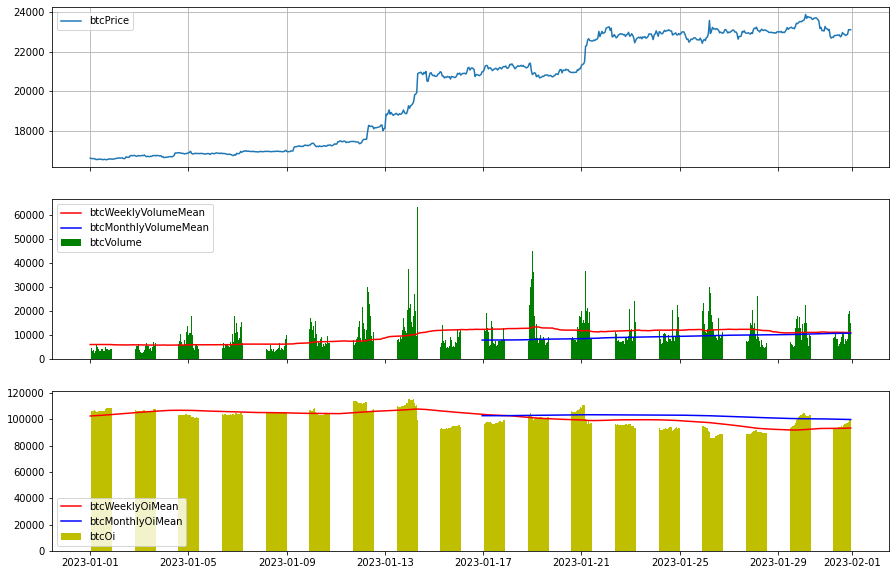

In [25]:
lastMonth = 31*24
figBtc, (axBtc, ax1Btc, ax2Btc) = plt.subplots(3,1,sharex=True, figsize=(15,10))
# figBtc.subplots_adjust(bottom=0.5)
axBtc.grid(True)
axBtc.plot(btcOiVolumeDf.iloc[-lastMonth:].close, label='btcPrice')
axBtc.legend()
ax1Btc.bar(btcOiVolumeDf.iloc[-lastMonth:].index, btcOiVolumeDf.iloc[-lastMonth:].volume, color='g', width=0.02, label='btcVolume')
ax1Btc.plot(ta.MA(btcOiVolumeDf.volume, shortPeriod).iloc[-lastMonth:], color='r', label='btcWeeklyVolumeMean')
ax1Btc.plot(ta.MA(btcOiVolumeDf.volume, longPeriod).iloc[-lastMonth:], color='b', label='btcMonthlyVolumeMean')
ax1Btc.legend(loc='upper left')
ax2Btc.bar(btcOiVolumeDf.iloc[-lastMonth:].index, btcOiVolumeDf.oi.iloc[-lastMonth:], color='y', width=0.02, label='btcOi')
ax2Btc.plot(ta.MA(btcOiVolumeDf.oi, shortPeriod).iloc[-lastMonth:], color='r', label='btcWeeklyOiMean')
ax2Btc.plot(ta.MA(btcOiVolumeDf.oi, longPeriod).iloc[-lastMonth:], color='b', label='btcMonthlyOiMean')
ax2Btc.legend()
figBtc.savefig('oiVolumePriceBtc')

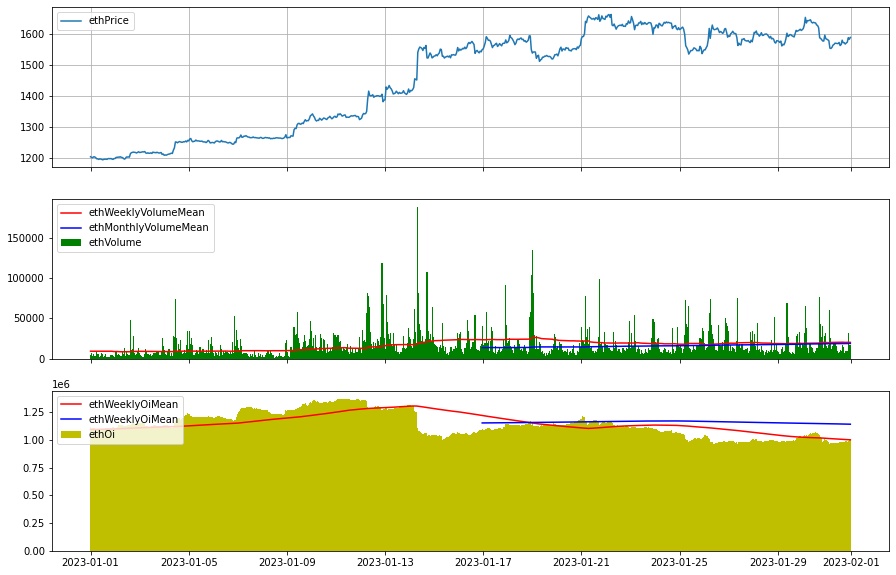

In [26]:
lastMonth = 31*24
figEth, (axEth,ax1Eth, ax2Eth) = plt.subplots(3,1,sharex=True, figsize=(15,10))
# figEth.subplots_adjust(bottom=0.5)
axEth.grid(True)
axEth.plot(ethOiVolumeDf.iloc[-lastMonth:].close, label='ethPrice')
axEth.legend(loc='upper left')
ax1Eth.bar(ethOiVolumeDf.iloc[-lastMonth:].index, ethOiVolumeDf.iloc[-lastMonth:].volume, color='g', width=0.045, label='ethVolume')
ax1Eth.plot(ta.MA(ethOiVolumeDf.volume, shortPeriod).iloc[-lastMonth:], color='r', label='ethWeeklyVolumeMean')
ax1Eth.plot(ta.MA(ethOiVolumeDf.volume, longPeriod).iloc[-lastMonth:], color='b', label='ethMonthlyVolumeMean')
ax1Eth.legend(loc='upper left')
ax2Eth.bar(ethOiVolumeDf.iloc[-lastMonth:].index, ethOiVolumeDf.oi.iloc[-lastMonth:], color='y', width=0.045, label='ethOi')
ax2Eth.plot(ta.MA(ethOiVolumeDf.oi, shortPeriod).iloc[-lastMonth:], color='r', label='ethWeeklyOiMean')
ax2Eth.plot(ta.MA(ethOiVolumeDf.oi, longPeriod).iloc[-lastMonth:], color='b', label='ethWeeklyOiMean')
ax2Eth.legend(loc='upper left')
figEth.savefig('oiVolumePriceEth')

In [27]:
close = oiVolumeDf.close.unstack()
volume = oiVolumeDf.volume.unstack()
oi = oiVolumeDf.oi.unstack()

In [28]:
oi

symbol                      btc          eth
datetime                                    
2022-12-20 00:00:00   99679.488  1061354.396
2022-12-20 01:00:00  100214.395  1057338.378
2022-12-20 02:00:00  100463.910  1057555.323
2022-12-20 03:00:00  101501.634  1061686.774
2022-12-20 04:00:00  101797.689  1062454.622
...                         ...          ...
2023-01-31 19:00:00   97022.316   985660.888
2023-01-31 20:00:00   97457.766   984310.435
2023-01-31 21:00:00   98378.574   992941.132
2023-01-31 22:00:00   99640.982   999166.504
2023-01-31 23:00:00  100021.193   997785.981

[1032 rows x 2 columns]

In [29]:
closeMaRatio = close.rolling(shortPeriod).mean()/close.rolling(longPeriod).mean()
volumeMaRatio = volume.rolling(shortPeriod).mean()/volume.rolling(longPeriod).mean()
oiMaRatio = oi.rolling(shortPeriod).mean()/oi.rolling(longPeriod).mean()

In [30]:
def cal_pctChange(data, lastDay, periodList=[7]):
    pctChangeDict = {}
    for period in periodList:
        pctChangeDict[str(period)+'Day'] = round((data.loc[lastDay]/data.loc[lastDay-timedelta(hours=period*24)]-1)*100, 2)
    pctChangeDf = pd.Series(pctChangeDict)
    return pctChangeDf

In [31]:
endTime = oiMaRatio.index[-1]
maChangeDf = pd.DataFrame({
    'btcCloseRatioPctChange': cal_pctChange(closeMaRatio.btc, endTime, [1, 3, 5, 8, 13]),
    'ethCloseRatioPctChange': cal_pctChange(closeMaRatio.eth, endTime, [1, 3, 5, 8, 13]),
    'btcVolumeRatioPctChange': cal_pctChange(volumeMaRatio.btc, endTime, [1, 3, 5, 8, 13]),
    'ethVolumeRatioPctChange': cal_pctChange(volumeMaRatio.eth, endTime, [1, 3, 5, 8, 13]),   
    'btcOpenInterestRatioPctChange': cal_pctChange(oiMaRatio.btc, endTime, [1, 3, 5, 8, 13]),
    'ethOpenInterestRatioPctChange': cal_pctChange(oiMaRatio.eth, endTime, [1, 3, 5, 8, 13]),
})

In [32]:
maChangeDfT = round(maChangeDf.T, 2)

In [33]:
maChangeDfT['avg'] = maChangeDfT.mean(axis=1)

In [34]:
maChangeDfT

1Day  3Day   5Day   8Day  13Day     avg
btcCloseRatioPctChange        -1.13 -2.86  -3.61  -3.59  -1.24  -2.486
ethCloseRatioPctChange        -1.37 -3.79  -5.77  -7.62  -7.21  -5.152
btcVolumeRatioPctChange       -2.69 -7.35 -18.08 -20.58 -36.41 -17.022
ethVolumeRatioPctChange       -0.55  0.15  -4.75 -10.96 -39.13 -11.048
btcOpenInterestRatioPctChange  0.72  2.23  -0.43  -3.10  -4.89  -1.094
ethOpenInterestRatioPctChange -0.88 -3.08  -6.69  -9.48 -12.06  -6.438

In [35]:
maChangeDfT.to_excel('RatioPctChange.xlsx')

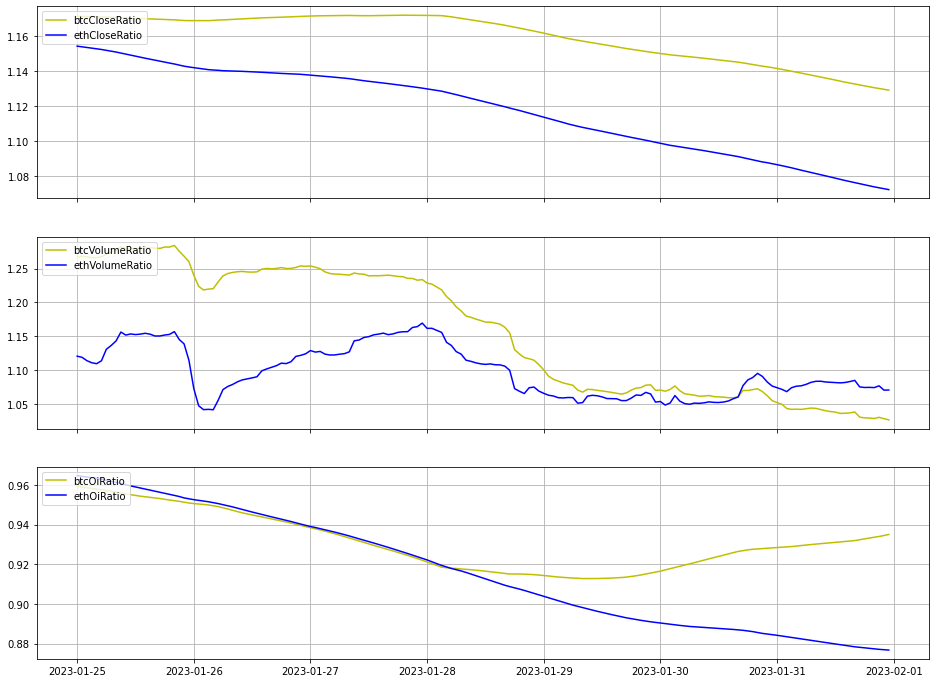

In [36]:
f2Coin, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(16,12))
ax1.plot(closeMaRatio.btc.iloc[-24*7:], 'y', label='btcCloseRatio')
ax1.plot(closeMaRatio.eth.iloc[-24*7:], 'b', label='ethCloseRatio')
ax1.legend(loc='upper left')
ax1.grid()
ax2.plot(volumeMaRatio.btc.iloc[-24*7:], 'y', label='btcVolumeRatio')
ax2.plot(volumeMaRatio.eth.iloc[-24*7:], 'b', label='ethVolumeRatio')
ax2.legend(loc='upper left')
ax2.grid()
ax3.plot(oiMaRatio.btc.iloc[-24*7:], 'y', label='btcOiRatio')
ax3.plot(oiMaRatio.eth.iloc[-24*7:], 'b', label='ethOiRatio')
ax3.legend(loc='upper left')
ax3.grid()
f2Coin.savefig('RatioChart')